# Preliminaries

## Dataset

In this set of exercises we will use the same dataset as from [week 3](week_3.ipynb). 


As before, we provide the data already curated in the following two files:

`RNA_expression_curated.csv`: [148 cell lines , 238 genes]

`drug_response_curated.csv`: [148 cell lines , YM155 drug]

The curated data can be read as `pandas` `DataFrame` in the following way:

In [1]:
import pandas as pd

gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

The goal of the exercises is to train support vector machine (SVM) and random forests classifiers on this dataset and explore and learn about their hyperparameters. 

## Tools

The `scikit-learn` library provides the required tools for support vector machines, as well as for random forest algorithms.

In [2]:
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import classification_report

Before proceeding, look up the documentation of the imported functions and read about their basic functionality. Below, we list some important parameters of SVMs and random forests that can be tuned during training.

#### Support Vector Machines (SVM)

`C`: error term.

`kernel`: similarity function ('linear', 'poly', 'sigmoid' or 'rbf')

`gamma`: kernel coef. for 'rbf', 'poly' and 'sigmoid' kernels. It can be thought of as the ‘spread’ of the kernel and therefore the decision region.

`degree`: degree for the 'poly' kernel.

`coef0`: independt term in the 'poly' and 'sigmoid' kernels


#### Random Forests

`n_estimators`: number of trees in our random forest.

`max_depth`: maximum number of levels in each decision tree

`max_features`: maximum number of features to consider per split in an individual tree.

`min_sample_leaf`: minimum number of data points per leaf node

`min_samples_split`: minimum number of data points placed in a node before the node is split

`oob_score`: the out-of-bag (OOB) error is the average error for each observation calculated using predictions from the trees that do not contain that observation in their respective bootstrap sample. Set this parameter to true.

`bootstrap`: method for sampling data points (with or without replacement). Set this parameter to true.

`criterion`: function used to measure the quality of the split (e.g. 'entropy' or 'gini')

# Exercises

## Support vector machines

The  `make_blobs` and `make_circles` functions can be used to generate linearly and not linearly separable toy datasets. 

In [3]:
# data generation: linearly separable
X, Y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

The following code illustrates how to train a linear SVM classifier and plot the data points, the separating hyperplane, the support vectors and the margins that pass through them (considering the training data)

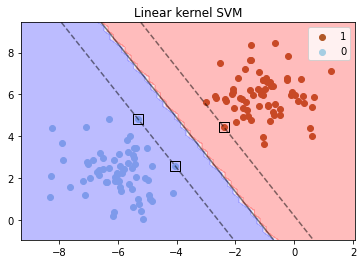

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# build the model
model = svm.SVC(kernel='linear', random_state=33)
model.fit(X_train, Y_train)

# create plot
fig, ax = plt.subplots()

# get colors from qualitative colormap 'Paired'
cmap = plt.cm.get_cmap('Paired')

# plot data points
ax.scatter(X_train.iloc[Y_train == 1, 0], X_train.iloc[Y_train == 1, 1],
           c=[cmap(11)], label='1')
ax.scatter(X_train.iloc[Y_train == 0, 0], X_train.iloc[Y_train == 0, 1],
           c=[cmap(0)], label='0')
ax.legend(loc='best')

# plot the decision function
# create grid to evaluate model
x1_min, x1_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
x2_min, x2_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x1_min, x1_max, .2),
                     np.arange(x2_min, x2_max, .2))

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Establish the class for each point in the contour
Z = model.predict(xy).reshape(XX.shape)

# Visualization of the contour
ax.contourf(XX, YY, Z, cmap='bwr', alpha=0.3)

# plot support vectors, whose are responsible for building the margins
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', marker='s')

ax.axis([x1_min, x1_max, x2_min, x2_max])
plt.axis('tight')
plt.title('Linear kernel SVM')
plt.show()

Train a radial basis function (RBF) SVM classifier with `gamma=0.5` and plot the results in the same way.

In [5]:
# data generation: not linearly separable
X, Y = make_circles(n_samples=200, noise=0.05, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

<p><font color='#770a0a'>When should a RBF kernel be used over a linear kernel? Motivate your answer.</font></p>

<p><font color='#770a0a'>Do we need to normalize the data before using a kernel function? Motivate your answer.
</font></p>

Linear SVM is a parametric model, an RBF kernel SVM isn't, and the complexity of the latter grows with the size of the training set. Not only is it more expensive to train an RBF kernel SVM, but you also have to keep the kernel matrix around, and the projection into this "infinite" higher dimensional space where the data becomes linearly separable is more expensive as well during prediction. Furthermore, you have more hyperparameters to tune, so model selection is more expensive as well! And finally, it's much easier to overfit a complex model!
In practice, it is less useful for efficiency (computational as well as predictive) performance reasons. So, the rule of thumb is: use linear SVMs (or logistic regression) for linear problems, and nonlinear kernels such as the Radial Basis Function kernel for non-linear problems.

The RBF kernel SVM decision region is actually also a linear decision region. What RBF kernel SVM actually does is to create non-linear combinations of your features to uplift your samples onto a higher-dimensional feature space where you can use a linear decision boundary to separate your classes:

Okay, above, I walked you through an intuitive example where we can visualize our data in 2 dimensions ... but what do we do in a real-world problem, i.e., a dataset with more than 2 dimensions? Here, we want to keep an eye on our objective function: minimizing the hinge-loss. We would setup a hyperparameter search (grid search, for example) and compare different kernels to each other. Based on the loss function (or a performance metric such as accuracy, F1, MCC, ROC auc, etc.) we could determine which kernel is "appropriate" for the given task.

## Predicting drug response on cell lines from gene expression data with SVMs

Explore the hyper-parameter space of an SVM classifier with cross-validation for the Genomics of Drug Sensitivity in Cancer (GDSC) dataset. The`GridSearchCV` function can be used to specify a grid of parameter values with the `param_grid` parameter.

Calculate the precision of your predictions, and compare your calculations with the results of `classification_report`, which displays many classification metrics.




In [37]:
import scipy.stats as stats
from sklearn.metrics import accuracy_score

x_ex = gene_expression
y_ex = drug_response
zscores = stats.zscore(drug_response)
labels = np.zeros(len(zscores))
for i in range(len(zscores)):
    if zscores[i] >= 0:
        labels[i] = 1
    else:
        labels[i] = 0
X_train, X_test, Y_train, Y_test = train_test_split(x_ex, labels, test_size=0.33, random_state=333)

In [38]:
model = svm.SVC()
model.fit(X_train, Y_train)
 
# print prediction results
predictions = model.predict(X_test)
#print(classification_report(Y_test, predictions))

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, Y_train)

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


grid_predictions = grid.predict(X_test)
 
# print classification report
print(classification_report(Y_test, grid_predictions))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.526 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.600 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.650 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.600 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.632 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.550 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.550 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.550 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.526 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.600 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.650 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.600 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.632 total time=   0.0s
[CV 1/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.550 total time=   0.0s
[CV 2/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.550 total time=   0.0s
[CV 3/5] END ...C=1, gamma=0.01, kernel=sigmoid;, score=0.550 total time=   0.0s
[CV 4/5] END ...C=1, gamma=0

[CV 1/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 3/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.550 total time=   0.0s
[CV 4/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 5/5] END C=10, gamma=0.0001, kernel=sigmoid;, score=0.632 total time=   0.0s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.550 total time=   0.0s
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.526 total time=   0.0s
[CV 1/5] END .......C=100, gamma=1, kernel=poly;, score=0.600 total time=   0.0s
[CV 2/5] END .......C=100, gamma=1, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/5] END .......C=100, g

[CV 3/5] END C=1000, gamma=0.01, kernel=sigmoid;, score=0.550 total time=   0.0s
[CV 4/5] END C=1000, gamma=0.01, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 5/5] END C=1000, gamma=0.01, kernel=sigmoid;, score=0.526 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.550 total time=   0.0s
[CV 2/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.750 total time=   0.0s
[CV 3/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.700 total time=   0.0s
[CV 4/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.600 total time=   0.0s
[CV 5/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.632 total time=   0.0s
[CV 1/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.600 total time=   0.0s
[CV 2/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.800 total time=   0.0s
[CV 3/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.650 total time=   0.0s
[CV 4/5] END ..C=1000, gamma=0.001, kernel=poly;, score=0.600 total time=   0.0s
[CV 5/5] END ..C=1000, gamma

In [39]:
# Calculate roc auc
roc_value = roc_auc_score(Y_test, predictions)
print("AUC is:", roc_value)

#Get accuracy
acc_value = accuracy_score(predictions, Y_test)
print('Accuracy score is:', acc_value)

AUC is: 0.5891544117647058
Accuracy score is: 0.5714285714285714


In [10]:
X = gene_expression
y = drug_response

# Build your classifier
classifier = svm.SVC()

# Train it on the entire training data set
classifier.fit(X_train, Y_train)

# Get predictions on the test set
y_pred = classifier.predict(X_test)

## Random forests

Follow the same steps as for SVM. Compare the two algorithms and report which one has better performance.

The random forests classifiers allows to perform feature selection. Evaluate the importance of features extracting the top 50 informative features. A bar plot (`plt.bar()`) can be a useful tool to visualize this. 



In [45]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               oob_score = True
                               )#max_features = 'sqrt'
# Fit on training data
model.fit(X_train, Y_train)

# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]


from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(Y_test, rf_probs)
print("AUC is:", roc_value)

#Get accuracy
acc_value = accuracy_score(rf_predictions, Y_test)
print('Accuracy score is:', acc_value)

# print prediction results
predictions = model.predict(X_test)
print(classification_report(Y_test, predictions))

AUC is: 0.7417279411764706
Accuracy score is: 0.6530612244897959
              precision    recall  f1-score   support

         0.0       0.78      0.66      0.71        32
         1.0       0.50      0.65      0.56        17

    accuracy                           0.65        49
   macro avg       0.64      0.65      0.64        49
weighted avg       0.68      0.65      0.66        49



Text(0.5, 1.0, '50 most informative features')

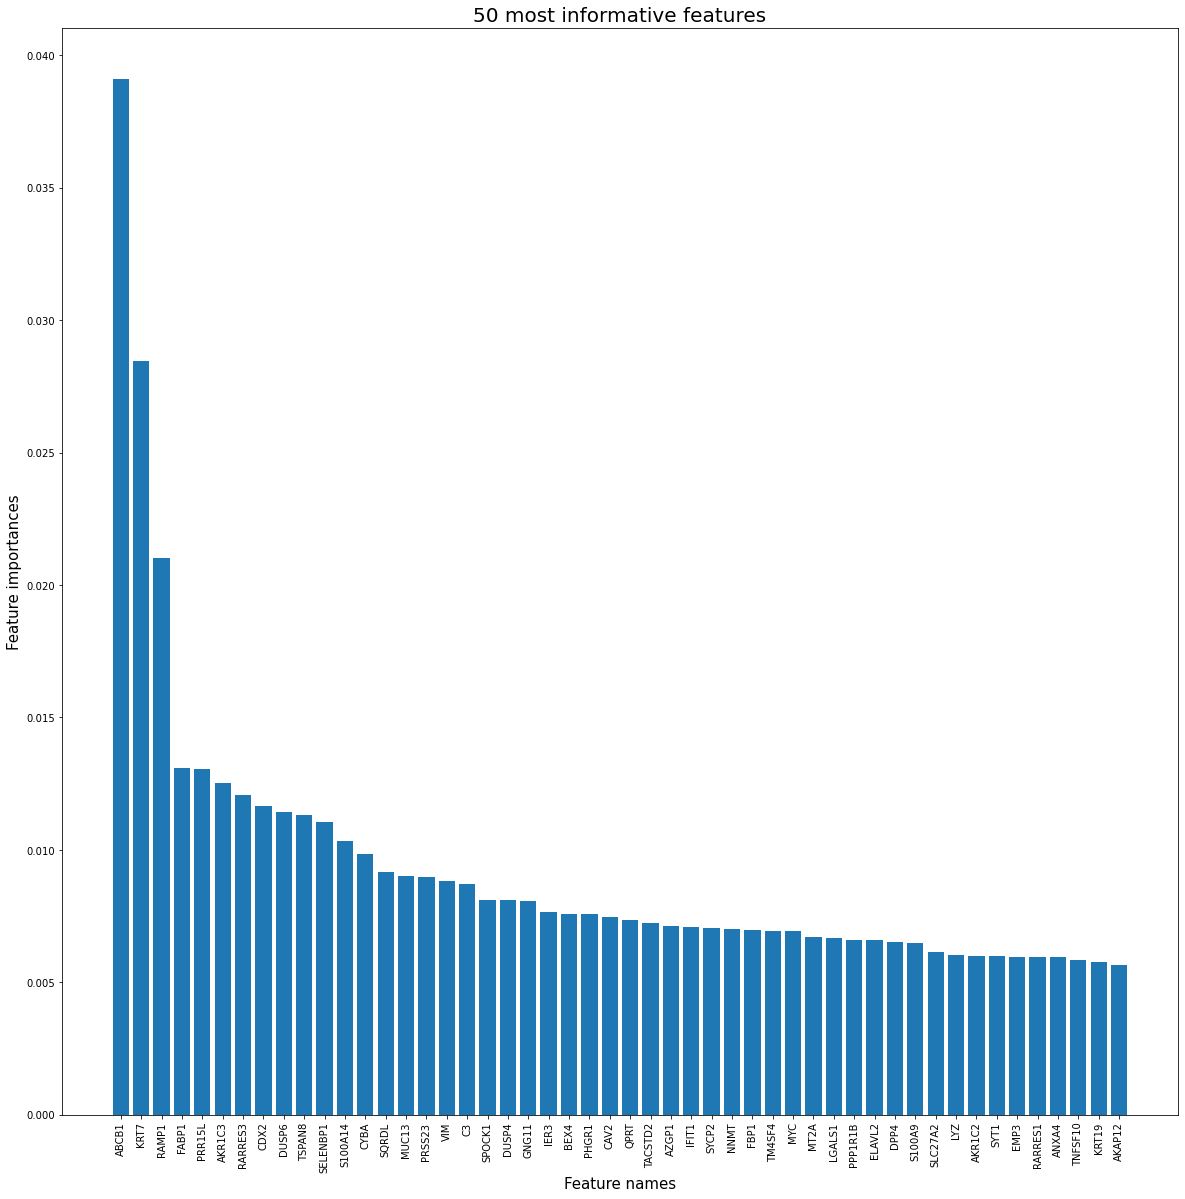

In [23]:
#features
feat_val = model.feature_importances_
feat_name = X.columns

# initialise data of lists.
data = {'Name': feat_name,
        'Value':feat_val}
 
# Create DataFrame
features = pd.DataFrame(data)

#plt.bar(feat_name, feat_val)
feat = features.sort_values('Value', ascending=False)


plt.figure(figsize=(20,20))
plt.bar(feat.iloc[0:50,0], feat.iloc[0:50,1])
plt.xticks(rotation = 'vertical')
plt.ylabel('Feature importances', fontsize = 15)
plt.xlabel('Feature names', fontsize = 15)
plt.title('50 most informative features', fontsize = 20)


## Biomedical applications

Driven by technological advances, there has recently been a dramatic increase in availability of biomedical data. Machine learning approaches are well suited to take advantage of this data and have been widely applied to many areas of biology. 

Example of these applications are genome annotation, biomarker identification, systems biology, genome data analysis, protein  function  prediction, protein  structure prediction, protein localization prediction, identification of protein interactions and drug discovery.

SVM and RF methods are among the most popular machine learning methods applied in bioinformatics or computational biology.

Perform a literature search and find a biomedical study in which SVM or RF is applied to obtain certain insights. <p><font color='#770a0a'>Explain the motivation behind using that specific algorithm in the study.
</font></p>